In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys
import os
import math
import spacy
sys.path.append("../")
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")

DEBUG:root:test


In [2]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
from dhira.data.data_manager import DataManager
from dhira.data.embedding_manager import EmbeddingManager
from dhira.tf.models.siamese.siamese_bilstm import SiameseBiLSTM
from tqdm import tqdm_notebook as tqdm

In [3]:
nlp = spacy.load('en_core_web_md')

In [4]:
from dhira.data.dataset.quora import QuoraDataset
from dhira.data.features.quora_feature import QuoraFeature
quora_dataset = QuoraDataset(name='quora-spacy',
                               train_files='../data/quora/processed/train_cleaned_train_split.csv',
                               val_files='../data/quora/processed/train_cleaned_val_split.csv',
                               test_files='../data/quora/processed/test_final.csv',
                               feature_type=QuoraFeature,
                               pad=True,
                               max_lengths={"num_sentence_words": 30})

INFO:dhira.data.dataset.internal.text:Reusing the pickle file quora-spacy-data_indexer.p.


In [5]:
data_manager = DataManager(dataset=quora_dataset, nlp=nlp)

In [6]:
get_train_data_gen, train_data_size = data_manager.get_train_data()

INFO:dhira.data.dataset.internal.dataset_base:Reusing the pickle file quora-spacy-train.p.
INFO:dhira.data.dataset.internal.text:Trying to load prefitted data_indexer... quora-spacy-data_indexer.p
INFO:dhira.data.dataset.internal.text:Instance max lengths {'num_sentence_words': 50}
INFO:dhira.data.dataset.internal.text:Padding lengths to length: {'num_sentence_words': 30}
INFO:dhira.data.dataset.internal.dataset_base:quora-spacy-train.p already exists


In [7]:
get_val_data_gen, val_data_size = data_manager.get_validation_data()

INFO:dhira.data.dataset.internal.dataset_base:Reusing the pickle file None.
INFO:dhira.data.dataset.internal.text:Instance max lengths {'num_sentence_words': 50}
INFO:dhira.data.dataset.internal.text:Padding lengths to length: {'num_sentence_words': 30}
INFO:dhira.data.dataset.internal.dataset_base:quora-spacy-val.p already exists


In [8]:
embedding_matrix = data_manager.embedding_matrix

In [9]:
embedding_matrix.shape

(848, 300)

In [10]:
batch_size = 256
num_epochs = 1
num_train_steps_per_epoch = int(math.ceil(train_data_size / batch_size))
num_val_steps = int(math.ceil(val_data_size / batch_size))
print('Number of train steps {} and validation steps {} for batch size {}'.format(num_train_steps_per_epoch, 
                                                                                  num_val_steps,
                                                                                  batch_size))

Number of train steps 1 and validation steps 1 for batch size 256


In [11]:
log_period = 50
val_period = 150
save_period = 200

In [12]:
model = ''
model = SiameseBiLSTM(run_id=3,
             word_vocab_size=embedding_matrix.shape[0], 
             word_embedding_dim=300, 
             word_embedding_matrix=embedding_matrix, 
             fine_tune_embeddings=True, 
             share_encoder_weights=True,
             rnn_output_mode='last',
             output_keep_prob=0.5,
             rnn_hidden_size=256)
model.compile()


INFO:dhira.tf.models.internal.base_tf_model:Writing logs to /home/mageswarand/.dhira/logs/SiameseBiLSTM/031503110118/
INFO:dhira.tf.models.internal.base_tf_model:log path /home/mageswarand/.dhira/logs/SiameseBiLSTM/031503110118/ does not exist, creating it
INFO:dhira.tf.models.internal.base_tf_model:Writing params to /home/mageswarand/.dhira/logs/SiameseBiLSTM/031503110118/SiameseBiLSTMparams.json
INFO:dhira.tf.models.internal.base_tf_model:Building graph...
/home/mageswarand/anaconda3/envs/tensorflow1.0/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [13]:
model.train(get_train_feature_generator=get_train_data_gen,
            get_val_feature_generator=get_val_data_gen,
            batch_size=batch_size,
            num_train_steps_per_epoch=num_train_steps_per_epoch,
            num_epochs=num_epochs,
            num_val_steps=num_val_steps,
            log_period=log_period,
            val_period=val_period,
            save_period=save_period,
            patience=0)

Writing to /home/mageswarand/.dhira/logs/SiameseBiLSTM/031503110118

--------------------------------------------------

tensorboard --logdir  /home/mageswarand/.dhira/logs/SiameseBiLSTM/031503110118

tensorboard --logdir  /home/mageswarand/.dhira/models/SiameseBiLSTM/03/checkpoints --port 6007
--------------------------------------------------


INFO:dhira.tf.models.internal.base_tf_model:Saving final model @ /home/mageswarand/.dhira/models/SiameseBiLSTM/03/SiameseBiLSTM-1


INFO:dhira.tf.models.siamese.siamese_bilstm:No model specific evaluations
INFO:dhira.tf.models.internal.base_tf_model:Finished 1 epochs!


'/home/mageswarand/.dhira/models/SiameseBiLSTM/03/SiameseBiLSTM-1'

In [14]:
get_test_data_gen, test_data_size = data_manager.get_test_data()

INFO:dhira.data.dataset.internal.dataset_base:Reusing the pickle file None.
INFO:dhira.data.dataset.internal.text:Instance max lengths {'num_sentence_words': 42}
INFO:dhira.data.dataset.internal.text:Padding lengths to length: {'num_sentence_words': 30}
INFO:dhira.data.dataset.internal.dataset_base:quora-spacy-test.p already exists


In [15]:
single_feature = quora_dataset.custom_input('How to learn Deep Learning?', 
                                            'What are methods to learn deep learning?')
single_feature_batch = DataManager.to_batch(single_feature)
pred = model.predict(single_feature_batch, '/opt/dhira/models/SiameseBiLSTM/01/')

INFO:dhira.data.data_manager:converting feature "<dhira.data.features.quora_feature.QuoraFeatureIndexed object at 0x7fe986f92f60>" to list of features
INFO:dhira.tf.models.internal.base_tf_model:Getting latest checkpoint in /opt/dhira/models/SiameseBiLSTM/01/
INFO:dhira.tf.models.internal.base_tf_model:Attempting to load checkpoint at /opt/dhira/models/SiameseBiLSTM/01/SiameseBiLSTM-1


INFO:tensorflow:Restoring parameters from /opt/dhira/models/SiameseBiLSTM/01/SiameseBiLSTM-1


INFO:tensorflow:Restoring parameters from /opt/dhira/models/SiameseBiLSTM/01/SiameseBiLSTM-1
INFO:dhira.tf.models.internal.base_tf_model:Successfully loaded /opt/dhira/models/SiameseBiLSTM/01/SiameseBiLSTM-1!


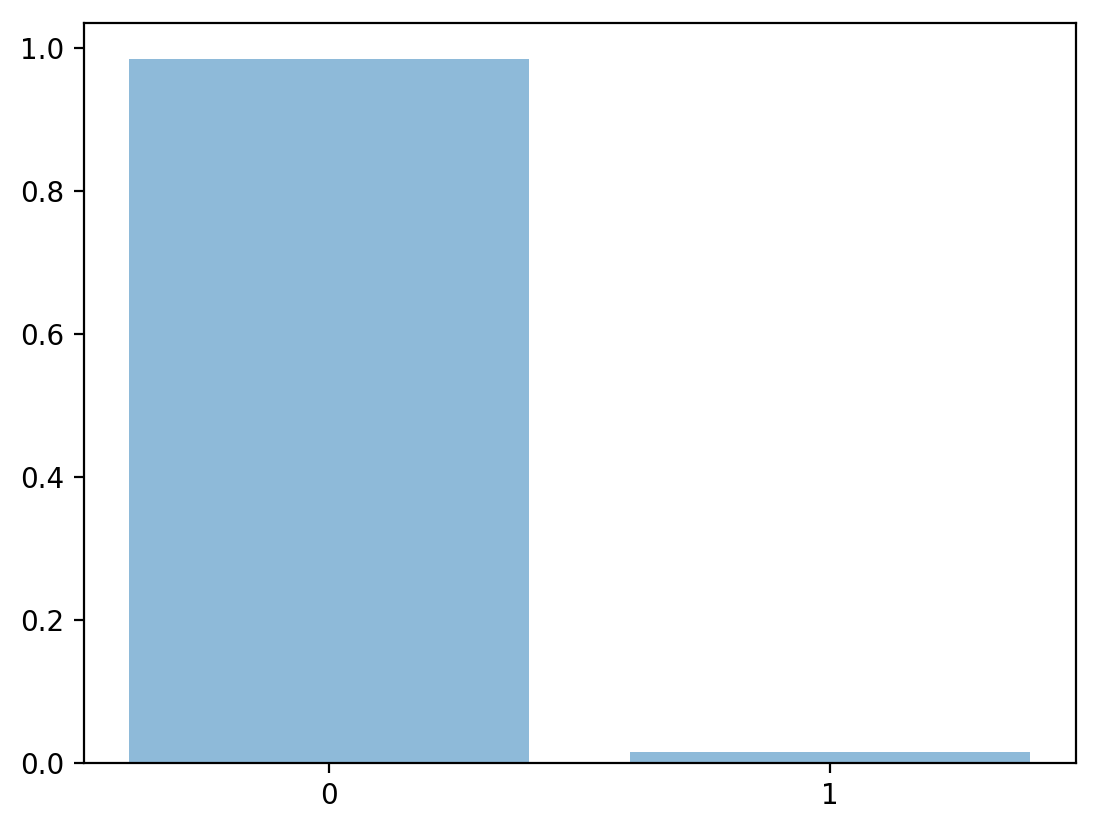

In [16]:
plt.bar([0,1], pred[0], align='center', alpha=0.5)
plt.xticks([0,1], [0,1])
plt.show()